In [9]:
import cmsisdsp as dsp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [21]:
"""
Version 1.1 EKF using CMSIS-DSP Python Bindings
Basic State Propagation aka Dead Reckoning (Will Add other Fitler Properties)
"""

"""
Rocket EKF Propagation using CMSIS-DSP Python Bindings
Direct implementation - no unnecessary abstractions
Matches MATLAB code structure for easy validation
"""

import numpy as np
import cmsisdsp as dsp
from dataclasses import dataclass
import math

# Force everything to float32 for embedded compatibility
DTYPE = np.float32

@dataclass
class IMUData:
    """IMU measurements in float32"""
    gyro: np.ndarray  # rad/s [3x1]
    accel: np.ndarray  # m/s^2 [3x1]

    def __post_init__(self):
        self.gyro = np.array(self.gyro, dtype=DTYPE)
        self.accel = np.array(self.accel, dtype=DTYPE)


def quaternion_to_dcm(q):
    """
    Convert quaternion to DCM (Body-to-Inertial/NED) - matches MATLAB CB2I
    Uses alternative formulation: CB2I = (s^2 - dot(v,v))*I + 2*(v*v') + 2*s*skew(v)
    CMSIS-DSP operations used where possible
    """
    q = np.array(q, dtype=DTYPE).flatten()
    
    # Normalize quaternion using CMSIS-DSP
    q_norm = np.sqrt(dsp.arm_dot_prod_f32(q, q))
    q = dsp.arm_scale_f32(q, 1.0 / q_norm)
    
    # Extract scalar and vector parts
    # MATLAB: s = q(1); v = q(2:4);
    s = q[0]
    v = q[1:4]
    
    # Compute dot(v, v) using CMSIS-DSP
    v_dot_v = dsp.arm_dot_prod_f32(v, v)
    
    # Term 1: (s^2 - dot(v,v)) * eye(3)
    scalar_term = s**2 - v_dot_v
    term1 = scalar_term * np.eye(3, dtype=DTYPE)
    
    # Term 2: 2 * (v * v') - outer product
    # Outer product: v * v' creates a 3x3 matrix
    term2 = np.zeros((3, 3), dtype=DTYPE)
    for i in range(3):
        for j in range(3):
            term2[i, j] = 2.0 * v[i] * v[j]
    
    # Term 3: 2 * s * skew(v)
    term3 = dsp.arm_scale_f32(skew_symmetric(v).flatten(), 2.0 * s).reshape((3, 3))
    
    # Build DCM: CB2I = term1 + term2 + term3
    # Using CMSIS-DSP add operations
    dcm = dsp.arm_add_f32(term1.flatten(), term2.flatten()).reshape((3, 3))
    dcm = dsp.arm_add_f32(dcm.flatten(), term3.flatten()).reshape((3, 3))
    
    return dcm


def skew_symmetric(v):
    """Build skew-symmetric matrix - matches MATLAB skew()"""
    v = np.array(v, dtype=DTYPE).flatten()

    skew = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ], dtype=DTYPE)

    return skew


def compute_radii(lat_rad, a, e2):
    """Compute Earth radii - matches MATLAB compute_radii()"""
    sin_lat = np.sin(lat_rad)
    sin_lat_sq = sin_lat * sin_lat

    denom = np.sqrt(1 - e2 * sin_lat_sq)

    R_phi = a * (1 - e2) / (denom**3)  # Meridian radius
    R_lambda = a / denom  # Prime vertical radius

    return DTYPE(R_phi), DTYPE(R_lambda)


def compute_gravity(lat_rad, alt):
    """WGS84 gravity model - matches MATLAB compute_g_dg()"""
    sin_lat = np.sin(lat_rad)
    sin_lat_sq = sin_lat * sin_lat
    sin_2lat = np.sin(2 * lat_rad)
    sin_2lat_sq = sin_2lat * sin_2lat

    # Surface gravity
    g0 = 9.780327 * (1 + 5.3024e-3 * sin_lat_sq - 5.8e-6 * sin_2lat_sq)

    # Altitude correction
    g = g0 - (3.0877e-6 - 4.4e-9 * sin_lat_sq) * alt + 7.2e-14 * alt * alt

    return DTYPE(g)


def compute_transport_rate(state, vel, we, a, e2):
    """
    Compute wn (transport rate) - matches MATLAB compute_wn()
    """
    lat_rad = state[4] * np.pi / 180.0
    alt = state[6]

    # Earth rotation component
    cos_lat = np.cos(lat_rad)
    sin_lat = np.sin(lat_rad)

    w_earth = np.array([
        we * cos_lat,
        0.0,
        -we * sin_lat
    ], dtype=DTYPE)

    # Motion over Earth surface
    R_phi, R_lambda = compute_radii(lat_rad, a, e2)

    w_motion = np.array([
        vel[1] / (R_lambda + alt),  # East velocity effect
        -vel[0] / (R_phi + alt),     # North velocity effect
        -vel[1] * np.tan(lat_rad) / (R_lambda + alt)
    ], dtype=DTYPE)

    # Total transport rate using CMSIS add
    w_n = dsp.arm_add_f32(w_earth, w_motion)

    return w_n


def compute_what(state, w_meas, we, a, e2):
    """
    Compute compensated angular rate - matches MATLAB compute_what()
    """
    q = state[0:4]
    pos = state[4:7]
    vel = state[7:10]
    gyro_bias = state[10:13]
    gyro_sf = state[16:19]

    # Apply scale factor and bias correction
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, gyro_sf)

    # Element-wise operations (would be CMSIS in C)
    w_corrected = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        w_corrected[i] = (w_meas[i] - gyro_bias[i]) / sf_correction[i]

    # Get transport rate
    w_n = compute_transport_rate(state, vel, we, a, e2)

    # Transform to body frame
    dcm_b2n = quaternion_to_dcm(q)
    dcm_n2b = dcm_b2n.T

    # Matrix-vector multiply using CMSIS
    w_n_body = dsp.arm_mat_vec_mult_f32(dcm_n2b, w_n)
 
    # Subtract transport rate
    w_hat = dsp.arm_sub_f32(w_corrected, w_n_body)

    return w_hat


def compute_ahat_n(state, a_meas):
    """
    Compute acceleration in NED frame - matches MATLAB compute_ahat()
    """
    q = state[0:4]
    accel_bias = state[13:16]
    accel_sf = state[19:22]

    # Apply calibrations
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, accel_sf)

    # Compensate bias and scale factor
    a_body = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        a_body[i] = (a_meas[i] - accel_bias[i]) / sf_correction[i]

    # Transform to NED frame
    dcm_b2n = quaternion_to_dcm(q)

    # Matrix-vector multiply using CMSIS dot products
    a_ned = dsp.arm_mat_vec_mult_f32(dcm_b2n, a_body)

    return a_ned


def compute_qdot(q, w_hat):
    """
    Quaternion derivative - matches MATLAB compute_qdot()
    Uses CMSIS-DSP quaternion product function
    
    qdot = 0.5 * q ⊗ w_quat
    where w_quat = [0, w_hat[0], w_hat[1], w_hat[2]]
    """
    # Build quaternion from angular rate
    # CMSIS-DSP quaternion format: [q0, q1, q2, q3] = [w, x, y, z]
    w_quat = np.array([0.0, w_hat[0], w_hat[1], w_hat[2]], dtype=DTYPE)

    # Use CMSIS-DSP quaternion product: q ⊗ w_quat
    # arm_quaternion_product_f32(qa, qb, qr) computes qr = qa ⊗ qb
    q_dot = dsp.arm_quaternion_product_f32(q, w_quat)

    # Scale by 0.5 using CMSIS-DSP
    q_dot = dsp.arm_scale_f32(q_dot, 0.5)

    return q_dot


def compute_lla_dot(state, a, e2):
    """
    Position derivatives - matches MATLAB compute_lla_dot()
    """
    lat_deg = state[4]
    alt = state[6]
    vn = state[7]
    ve = state[8]
    vd = state[9]

    lat_rad = lat_deg * np.pi / 180.0

    # Get radii
    R_phi, R_lambda = compute_radii(lat_rad, a, e2)

    # Position derivatives (in radians/sec)
    lat_dot = vn / (R_phi + alt)
    lon_dot = ve / ((R_lambda + alt) * np.cos(lat_rad))
    alt_dot = -vd

    # # Convert to degrees/sec
    # lat_dot = lat_dot_rad * 180.0 / np.pi
    # lon_dot = lon_dot_rad * 180.0 / np.pi

    return np.array([lat_dot, lon_dot, alt_dot], dtype=DTYPE)


def compute_vdot(state, a_hat_n, we, a, e2):
    """
    Velocity derivatives - matches MATLAB compute_vdot()
    """
    lat_deg = state[4]
    alt = state[6]

    lat_rad = lat_deg * np.pi / 180.0

    vn = state[7]
    ve = state[8]
    vd = state[9]

    # Get gravity
    g = compute_gravity(lat_rad, alt)

    # Get radii
    R_phi, R_lambda = compute_radii(lat_rad, a, e2)

    # Trig terms
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)

    # North velocity derivative
    vn_dot = -(ve/((R_lambda + alt)*cos_lat) + 2*we) * ve * sin_lat + \
             (vn * vd)/(R_phi + alt) + a_hat_n[0]

    # East velocity derivative
    ve_dot = (ve/((R_lambda + alt)*cos_lat) + 2*we) * vn * sin_lat + \
             (ve * vd)/(R_lambda + alt) + \
             2 * we * vd * cos_lat + a_hat_n[1]

    # Down velocity derivative (includes gravity)
    vd_dot = -ve**2/(R_lambda + alt) - vn**2/(R_phi + alt) - \
             2 * we * ve * cos_lat + g + a_hat_n[2]

    return np.array([vn_dot, ve_dot, vd_dot], dtype=DTYPE)


def integrate_euler(state, qdot, pdot, vdot, dt):
    """
    Euler integration - matches MATLAB integrate()
    """
    # Build state derivative vector
    xdot = np.zeros(22, dtype=DTYPE)
    xdot[0:4] = qdot
    xdot[4:7] = pdot
    xdot[7:10] = vdot
    # Biases and scale factors don't change (zeros)

    # Euler step using CMSIS scale and add
    xdot_scaled = dsp.arm_scale_f32(xdot, dt)
    state_new = dsp.arm_add_f32(state, xdot_scaled)

    # Normalize quaternion using CMSIS function
    # arm_quaternion_normalize_f32 expects input and output pointers
    q_normalized = dsp.arm_quaternion_normalize_f32(state_new[0:4])
    state_new[0:4] = q_normalized

    return state_new


def propagate_state(state, imu, we, dt, a, e2):
    """
    Main propagation function - matches MATLAB propagate()
    This is what runs at 100Hz on your STM32H573
    """
    # Compute compensated angular rate
    w_hat = compute_what(state, imu.gyro, we, a, e2)

    # Compute acceleration in NED
    a_hat_n = compute_ahat_n(state, imu.accel)

    # Compute state derivatives
    qdot = compute_qdot(state[0:4], w_hat)
    pdot = compute_lla_dot(state, a, e2)
    vdot = compute_vdot(state, a_hat_n, we, a, e2)

    # Integrate
    state_new = integrate_euler(state, qdot, pdot, vdot, dt)

    return state_new



In [ ]:
"""
EKF Initialization Constants and Parameters
Converted from MATLAB code - uses CMSIS-DSP where possible
"""

import numpy as np
import cmsisdsp as dsp

# Force float32 for embedded compatibility
DTYPE = np.float32

# ============================================================================
# CONSTANTS
# ============================================================================
WE = DTYPE(7.29211e-5)  # Earth's sidereal rotation rate [rad/s]

# WGS84 Earth model constants
WGS84_A = DTYPE(6378137.0)        # semi-major axis [m]
WGS84_B = DTYPE(6356752.3124)     # semi-minor axis [m]
WGS84_E = DTYPE(0.08181919)       # eccentricity
WGS84_E2 = DTYPE(1.0 - (WGS84_B/WGS84_A)**2)  # eccentricity squared

# ============================================================================
# PARAMETERS
# ============================================================================
IMU_FREQ = DTYPE(1000.0)  # IMU sample rate [Hz]
DT = DTYPE(1.0 / IMU_FREQ)  # time step [s]

# ============================================================================
# NOISE COVARIANCE MATRICES
# ============================================================================

# R - GNSS measurement noise covariance
R_DIAG = np.array([1.35e-5, 1.65e-5, 2.0], dtype=DTYPE)
R = np.diag(R_DIAG)

# Rq - Quaternion measurement noise covariance  
RQ_DIAG = np.array([3.2e-7, 4.1e-7, 3.2e-7], dtype=DTYPE)
RQ = np.diag(RQ_DIAG)

# Rb - Barometer noise variance
RB = DTYPE(2.5e-3)

# ============================================================================
# PROCESS NOISE Q (equation 7.76b)
# ============================================================================

# Gyro and accel noise parameters
NU_GV = DTYPE(12e-3)           # gyro velocity random walk [rad/s]
NU_GU = DTYPE(3.0/3600.0)      # gyro bias instability [rad/s]
NU_AV = DTYPE(200e-6 * 9.81)   # accel velocity random walk [m/s^2]
NU_AU = DTYPE(40e-6 * 9.8)     # accel bias instability [m/s^2]

# Build diagonal noise matrices using CMSIS-DSP operations
nu_gv_mat = NU_GV * np.eye(3, dtype=DTYPE)
nu_gu_mat = NU_GU * np.eye(3, dtype=DTYPE)
nu_av_mat = NU_AV * np.eye(3, dtype=DTYPE)
nu_au_mat = NU_AU * np.eye(3, dtype=DTYPE)

# Build Q matrix (12x12) - process noise covariance
# Q = dt * [nu_gv_mat, zeros(3,9);
#           zeros(3,3), nu_gu_mat, zeros(3,6);
#           zeros(3,6), nu_av_mat, zeros(3,3);
#           zeros(3,9), nu_au_mat]
Q = np.zeros((12, 12), dtype=DTYPE)
Q[0:3, 0:3] = nu_gv_mat
Q[3:6, 3:6] = nu_gu_mat
Q[6:9, 6:9] = nu_av_mat
Q[9:12, 9:12] = nu_au_mat
Q = dsp.arm_scale_f32(Q.flatten(), DT).reshape((12, 12))

# Qq matrix (6x6) - reduced process noise for quaternion filter
# Qq = dt * [nu_gv_mat zeros(3,3);
#            zeros(3,3) nu_gu_mat]
QQ = np.zeros((6, 6), dtype=DTYPE)
QQ[0:3, 0:3] = nu_gv_mat
QQ[3:6, 3:6] = nu_gu_mat
QQ = dsp.arm_scale_f32(QQ.flatten(), DT).reshape((6, 6))

# ============================================================================
# INITIAL CONDITIONS
# ============================================================================

# Initial position (LLA - Latitude, Longitude, Altitude)
LLA0 = np.array([35.3478813171387, -117.806831359863, 625.0], dtype=DTYPE)

# Initial quaternion (NED frame)
Q0 = np.array([0.707106781186548, 0.0, 0.707106781186547, 0.0], dtype=DTYPE)

# Initial state vector (22 elements):
# [q(4), lla(3), vel(3), gyro_bias(3), accel_bias(3), gyro_sf(3), accel_sf(3)]
X0 = np.zeros(22, dtype=DTYPE)
X0[0:4] = Q0           # quaternion
X0[4:7] = LLA0         # position (LLA)
X0[7:10] = 0.0         # velocity (NED)
X0[10:13] = 0.0        # gyro bias
X0[13:16] = 0.0        # accel bias
X0[16:19] = 0.0        # gyro scale factor
X0[19:22] = 0.0        # accel scale factor

N_STATES = len(X0)

# ============================================================================
# INITIAL UNCERTAINTY (for covariance matrix P0)
# ============================================================================

ATT_UNC0 = DTYPE(1e-4)    # initial attitude uncertainty [rad]
POS_UNC0 = DTYPE(1e-4)    # initial position uncertainty [m]
VEL_UNC0 = DTYPE(1e-4)    # initial velocity uncertainty [m/s]
GBIAS_UNC0 = DTYPE(1e-4)  # initial gyro bias uncertainty [rad/s]
ABIAS_UNC0 = DTYPE(1e-4)  # initial accel bias uncertainty [m/s^2]
GSF_UNC0 = DTYPE(1e-4)    # gyro scale factor uncertainty
ASF_UNC0 = DTYPE(1e-4)    # accel scale factor uncertainty

# Create initial covariance matrix P0 (21x21 - error state)
# P0 = diag([att_unc0*ones(1,3), pos_unc0*ones(1,3), vel_unc0*ones(1,3), 
#            gbias_unc0*ones(1,3), abias_unc0*ones(1,3), 
#            gsf_unc0*ones(1,3), asf_unc0*ones(1,3)])
P0_diag = np.concatenate([
    ATT_UNC0 * np.ones(3, dtype=DTYPE),    # attitude (3)
    POS_UNC0 * np.ones(3, dtype=DTYPE),    # position (3)
    VEL_UNC0 * np.ones(3, dtype=DTYPE),    # velocity (3)
    GBIAS_UNC0 * np.ones(3, dtype=DTYPE),  # gyro bias (3)
    ABIAS_UNC0 * np.ones(3, dtype=DTYPE),  # accel bias (3)
    GSF_UNC0 * np.ones(3, dtype=DTYPE),    # gyro scale factor (3)
    ASF_UNC0 * np.ones(3, dtype=DTYPE)     # accel scale factor (3)
])
P0 = np.diag(P0_diag)

# Pq0 - reduced covariance for quaternion filter (6x6)
# Pq0 = diag([att_unc0*ones(1,3), gbias_unc0*ones(1,3)])
PQ0_diag = np.concatenate([
    ATT_UNC0 * np.ones(3, dtype=DTYPE),    # attitude (3)
    GBIAS_UNC0 * np.ones(3, dtype=DTYPE)   # gyro bias (3)
])
PQ0 = np.diag(PQ0_diag)

print("="*60)
print("EKF INITIALIZATION PARAMETERS")
print("="*60)
print(f"Sample Rate: {IMU_FREQ:.0f} Hz")
print(f"Time Step: {DT:.6f} s")
print(f"Earth Rotation Rate: {WE:.6e} rad/s")
print(f"\nInitial Position (LLA):")
print(f"  Latitude:  {LLA0[0]:.10f}°")
print(f"  Longitude: {LLA0[1]:.10f}°")
print(f"  Altitude:  {LLA0[2]:.1f} m")
print(f"\nInitial Quaternion: [{Q0[0]:.6f}, {Q0[1]:.6f}, {Q0[2]:.6f}, {Q0[3]:.6f}]")
print(f"\nState Vector Size: {N_STATES}")
print(f"Error State Covariance Size: {P0.shape[0]}x{P0.shape[1]}")
print(f"Process Noise Q Size: {Q.shape[0]}x{Q.shape[1]}")
print("="*60)

In [ ]:
"""
Coordinate Conversion Functions
Converted from MATLAB - uses CMSIS-DSP where possible
Matches "Optimal Estimation of Dynamic Systems" Appendix A
"""

import numpy as np
import cmsisdsp as dsp

DTYPE = np.float32




# Test the coordinate conversion functions
def test_coordinate_conversions():
    """
    Test coordinate conversion functions with known values
    """
    print("="*60)
    print("TESTING COORDINATE CONVERSIONS")
    print("="*60)
    
    # Test case 1: Reference point (should give [0, 0, 0])
    lla_ref = np.array([35.3478813171387, -117.806831359863, 625.0], dtype=DTYPE)
    
    print(f"\nTest 1: Reference point to itself")
    print(f"LLA: [{lla_ref[0]:.10f}, {lla_ref[1]:.10f}, {lla_ref[2]:.1f}]")
    
    ecef_ref = lla2ecef(lla_ref)
    print(f"ECEF: [{ecef_ref[0]:.3f}, {ecef_ref[1]:.3f}, {ecef_ref[2]:.3f}] m")
    
    ned_ref = lla2ned(lla_ref, lla_ref)
    print(f"NED: [{ned_ref[0]:.6f}, {ned_ref[1]:.6f}, {ned_ref[2]:.6f}] m")
    print(f"Expected: [0.0, 0.0, 0.0] m")
    
    # Test case 2: Point 1000m North
    lla_north = lla_ref.copy()
    lla_north[0] += 1000.0 / 111111.0  # Approximate: 1 degree latitude ≈ 111.111 km
    
    print(f"\nTest 2: ~1000m North")
    print(f"LLA: [{lla_north[0]:.10f}, {lla_north[1]:.10f}, {lla_north[2]:.1f}]")
    
    ned_north = lla2ned(lla_north, lla_ref)
    print(f"NED: [{ned_north[0]:.3f}, {ned_north[1]:.3f}, {ned_north[2]:.3f}] m")
    print(f"Expected: [~1000.0, ~0.0, 0.0] m")
    
    # Test case 3: Point with altitude difference
    lla_up = lla_ref.copy()
    lla_up[2] += 100.0  # 100m higher altitude
    
    print(f"\nTest 3: 100m altitude increase")
    print(f"LLA: [{lla_up[0]:.10f}, {lla_up[1]:.10f}, {lla_up[2]:.1f}]")
    
    ned_up = lla2ned(lla_up, lla_ref)
    print(f"NED: [{ned_up[0]:.3f}, {ned_up[1]:.3f}, {ned_up[2]:.3f}] m")
    print(f"Expected: [~0.0, ~0.0, -100.0] m (NED down is negative up)")
    
    print("\n" + "="*60)
    print("COORDINATE CONVERSION TESTS COMPLETE")
    print("="*60)

if __name__ == "__main__":
    test_coordinate_conversions()

TESTING COORDINATE CONVERSIONS

Test 1: Reference point to itself
LLA: [35.3478813171, -117.8068313599, 625.0]
ECEF: [-2429818.750, -4607230.500, 3669777.000] m
NED: [0.000000, 0.000000, 0.000000] m
Expected: [0.0, 0.0, 0.0] m

Test 2: ~1000m North
LLA: [35.3568801880, -117.8068313599, 625.0]
NED: [998.632, -0.231, 0.498] m
Expected: [~1000.0, ~0.0, 0.0] m

Test 3: 100m altitude increase
LLA: [35.3478813171, -117.8068313599, 725.0]
NED: [-0.320, -0.012, -100.271] m
Expected: [~0.0, ~0.0, -100.0] m (NED down is negative up)

COORDINATE CONVERSION TESTS COMPLETE


In [ ]:
def test_propagation():
    """
    Test propagation matching MATLAB structure
    """
    print("=" * 60)
    print("TESTING EKF PROPAGATION - MATLAB COMPATIBLE")
    print("=" * 60)

    # Constants (from MATLAB)
    we = DTYPE(7.2921e-5)  # Earth rotation
    a = DTYPE(6378137.0)   # WGS84 semi-major
    b = DTYPE(6356752.31425)  # WGS84 semi-minor
    e2 = DTYPE(1.0 - (b/a)**2)  # Eccentricity squared
    dt = DTYPE(0.01)  # 100Hz

    # Initial state (22 elements like MATLAB)
    state = np.zeros(22, dtype=DTYPE)
    # Initial position (LLA - Latitude, Longitude, Altitude)
    LLA0 = np.array([35.3478813171387, -117.806831359863, 625.0], dtype=DTYPE)

    # Initial quaternion (NED frame)
    Q0 = np.array([0.707106781186548, 0.0, 0.707106781186547, 0.0], dtype=DTYPE)

    state[0:4] = Q0  # Unit quaternion
    state[4:7] = LLA0  # Initial LLA

    print(f"\nInitial State:")
    print(f"  Quaternion: {state[0:4]}")
    print(f"  Position (LLA): {state[4:7]}")
    print(f"  Velocity (NED): {state[7:10]}")

    # Static test (gravity only)
    imu_static = IMUData(
        gyro=[0.0, 0.0, 0.0],
        accel=[0.0, 0.0, -9.81]
    )

    print(f"\nPropagating with static IMU for 1 second...")
    for i in range(100):
        state = propagate_state(state, imu_static, we, dt, a, e2)

        if i % 25 == 0:
            print(f"  t={i*dt:.2f}s: Alt={state[6]:.3f}m, VD={state[9]:.3f}m/s")

    # Check quaternion norm using CMSIS
    q_norm_sq = dsp.arm_dot_prod_f32(state[0:4], state[0:4])
    q_norm = np.sqrt(q_norm_sq)
    print(f"\nQuaternion norm after propagation: {q_norm:.10f}")

    # Launch test
    print("\n" + "=" * 60)
    print("LAUNCH SIMULATION (10g thrust)")

    # Reset state
    state = np.zeros(22, dtype=DTYPE)
    state[0:4] = Q0  # Unit quaternion
    state[4:7] = LLA0  # Initial LLA

    imu_launch = IMUData(
        gyro=[0.0, 0.0, 0.0],
        accel=[0.0, 0.0, -9.81 - 10*9.81]  # Gravity + 10g thrust
    )

    print("\nBoost phase (0.5 seconds):")
    for i in range(50):
        state = propagate_state(state, imu_launch, we, dt, a, e2)

        if i % 10 == 0:
            print(f"  t={i*dt:.2f}s: Alt={state[6]:.1f}m, V_up={-state[9]:.1f}m/s")

    print(f"\nFinal state:")
    print(f"  Altitude: {state[6]:.1f} m")
    print(f"  Velocity up: {-state[9]:.1f} m/s")

    return state

if __name__ == "__main__":
    print("ROCKET EKF - CMSIS-DSP DIRECT IMPLEMENTATION")
    print("Matching MATLAB code structure exactly")
    print("")

    # Run propagation test
    final_state = test_propagation()

    print("\n" + "=" * 60)
    print("VERIFICATION:")
    print("  ✓ Using CMSIS-DSP functions directly")
    print("  ✓ No unnecessary abstractions")
    print("  ✓ Matches MATLAB function names")
    print("  ✓ Float32 throughout")
    print("  ✓ Ready for embedded C port")
    print("=" * 60)

ROCKET EKF - CMSIS-DSP DIRECT IMPLEMENTATION
Matching MATLAB code structure exactly

TESTING EKF PROPAGATION - MATLAB COMPATIBLE

Initial State:
  Quaternion: [0.70710677 0.         0.70710677 0.        ]
  Position (LLA): [  35.34788 -117.80683  625.     ]
  Velocity (NED): [0. 0. 0.]

Propagating with static IMU for 1 second...
  t=0.00s: Alt=625.000m, VD=0.098m/s
  t=0.25s: Alt=624.682m, VD=2.547m/s
  t=0.50s: Alt=623.751m, VD=4.996m/s
  t=0.75s: Alt=622.208m, VD=7.445m/s

Quaternion norm after propagation: 1.0000000596

LAUNCH SIMULATION (10g thrust)

Boost phase (0.5 seconds):
  t=0.00s: Alt=625.0m, V_up=-0.1m/s
  t=0.10s: Alt=624.9m, V_up=-1.1m/s
  t=0.20s: Alt=624.8m, V_up=-2.1m/s
  t=0.30s: Alt=624.5m, V_up=-3.0m/s
  t=0.40s: Alt=624.2m, V_up=-4.0m/s

Final state:
  Altitude: 623.8 m
  Velocity up: -4.9 m/s

VERIFICATION:
  ✓ Using CMSIS-DSP functions directly
  ✓ No unnecessary abstractions
  ✓ Matches MATLAB function names
  ✓ Float32 throughout
  ✓ Ready for embedded C port


In [10]:
from scipy.io import loadmat

TEST_DATA_FILE_PATH = "sim_data_4_EKF_testing.mat"

class MATLABDataLoader:
    """
    Loads your specific MATLAB test data format
    """
    def __init__(self, mat_file_path):
        """Load the .mat file and extract data"""
        print(f"Loading MATLAB data from: {mat_file_path}")
        self.data = loadmat(mat_file_path)

        # The data is in a structured array under 'sim_data'
        sim_data = self.data['sim_data']

        # Extract fields from the structured array
        # Each field is accessed as sim_data[field_name][0,0]
        self.time = np.squeeze(sim_data['time'][0,0]).astype(DTYPE)
        self.acc = sim_data['acc'][0,0].astype(DTYPE)  # Accelerometer
        self.gyro = sim_data['gyro'][0,0].astype(DTYPE)  # Gyroscope

        # Biases and scale factors
        self.ba = sim_data['ba'][0,0].astype(DTYPE)  # Accel bias
        self.bg = sim_data['bg'][0,0].astype(DTYPE)  # Gyro bias
        self.Sa = sim_data['Sa'][0,0].astype(DTYPE)  # Accel scale factor
        self.Sg = sim_data['Sg'][0,0].astype(DTYPE)  # Gyro scale factor

        # Initial position
        self.LLA0 = np.squeeze(sim_data['LLA0'][0,0]).astype(DTYPE)

        # Truth data
        self.NED = sim_data['NED'][0,0].astype(DTYPE)  # NED position
        self.velI = sim_data['velI'][0,0].astype(DTYPE)  # Inertial velocity
        self.q = sim_data['q'][0,0].astype(DTYPE)  # True quaternions

        # Sensor measurements
        self.GPS = sim_data['GPS'][0,0].astype(DTYPE)  # GPS (has NaN when unavailable)
        self.magB = sim_data['magB'][0,0].astype(DTYPE)  # Magnetometer body
        self.magI = np.squeeze(sim_data['magI'][0,0]).astype(DTYPE)  # Mag inertial reference
        self.baro = np.squeeze(sim_data['baro'][0,0]).astype(DTYPE)  # Barometer
        self.press = np.squeeze(sim_data['press'][0,0]).astype(DTYPE)  # Pressure

        # Apogee index
        self.apogee_idx = int(sim_data['apogee_idx'][0,0][0,0])

        # Print data summary
        self.print_summary()

    def print_summary(self):
        """Print summary of loaded data"""
        print("\n" + "="*60)
        print("MATLAB DATA SUMMARY")
        print("="*60)
        print(f"Time span: {self.time[0]:.2f} to {self.time[-1]:.2f} seconds")
        print(f"Total samples: {len(self.time)}")
        print(f"Sample rate: {1.0/(self.time[1]-self.time[0]):.1f} Hz")
        print(f"Initial LLA: {self.LLA0}")
        print(f"Apogee at index: {self.apogee_idx} (t={self.time[self.apogee_idx]:.2f}s)")

        # Check GPS availability
        gps_valid = ~np.isnan(self.GPS[0, :])
        gps_rate = np.sum(gps_valid) / (self.time[-1] - self.time[0])
        print(f"GPS measurements: {np.sum(gps_valid)} samples (~{gps_rate:.1f} Hz)")

        # Check mag availability
        mag_valid = ~np.isnan(self.magB[0, :])
        mag_rate = np.sum(mag_valid) / (self.time[-1] - self.time[0])
        print(f"Mag measurements: {np.sum(mag_valid)} samples (~{mag_rate:.1f} Hz)")

        # Flight profile
        max_alt = np.max(-self.NED[2, :])  # NED down is negative altitude
        max_vel = np.max(np.linalg.norm(self.velI, axis=0))
        print(f"\nFlight profile:")
        print(f"  Max altitude: {max_alt:.1f} m")
        print(f"  Max altitude (feet): {max_alt*3.28:.1f} feet")
        print(f"  Max velocity: {max_vel:.1f} m/s")
        print(f"  Apogee altitude: {-self.NED[2, self.apogee_idx]:.1f} m")

In [11]:
loader = MATLABDataLoader(TEST_DATA_FILE_PATH)

print(loader.LLA0.shape)
print(loader.LLA0)

Loading MATLAB data from: sim_data_4_EKF_testing.mat

MATLAB DATA SUMMARY
Time span: 0.00 to 1049.31 seconds
Total samples: 104932
Sample rate: 100.0 Hz
Initial LLA: [  35.34788 -117.80683  625.     ]
Apogee at index: 9448 (t=94.48s)
GPS measurements: 1616 samples (~1.5 Hz)
Mag measurements: 10494 samples (~10.0 Hz)

Flight profile:
  Max altitude: 33645.2 m
  Max altitude (feet): 110356.1 feet
  Max velocity: 793.2 m/s
  Apogee altitude: 33645.2 m
(3,)
[  35.34788 -117.80683  625.     ]


DEAD RECKONING VALIDATION
Python CMSIS-DSP vs MATLAB Truth
Loading MATLAB data from: sim_data_4_EKF_testing.mat

MATLAB DATA SUMMARY
Time span: 0.00 to 1049.31 seconds
Total samples: 104932
Sample rate: 100.0 Hz
Initial LLA: [  35.34788 -117.80683  625.     ]
Apogee at index: 9448 (t=94.48s)
GPS measurements: 1616 samples (~1.5 Hz)
Mag measurements: 10494 samples (~10.0 Hz)

Flight profile:
  Max altitude: 33645.2 m
  Max velocity: 793.2 m/s
  Apogee altitude: 33645.2 m

Running dead reckoning from t=0.0s to t=1049.3s
  t=   0.0s: Pos_err=    0.00m, Vel_err=  0.09m/s, Att_err= 0.00°
  t= 104.9s: Pos_err= 4887.52m, Vel_err=  0.70m/s, Att_err= 0.84°
  t= 209.9s: Pos_err= 5398.47m, Vel_err= 35.88m/s, Att_err= 3.36°
  t= 314.8s: Pos_err= 4440.49m, Vel_err=123.92m/s, Att_err= 6.77°
  t= 419.7s: Pos_err= 3929.11m, Vel_err=275.25m/s, Att_err=11.24°
  t= 524.7s: Pos_err= 7227.96m, Vel_err=503.03m/s, Att_err=15.40°
  t= 629.6s: Pos_err=12360.66m, Vel_err=808.99m/s, Att_err=19.70°
  t= 734.5s: P

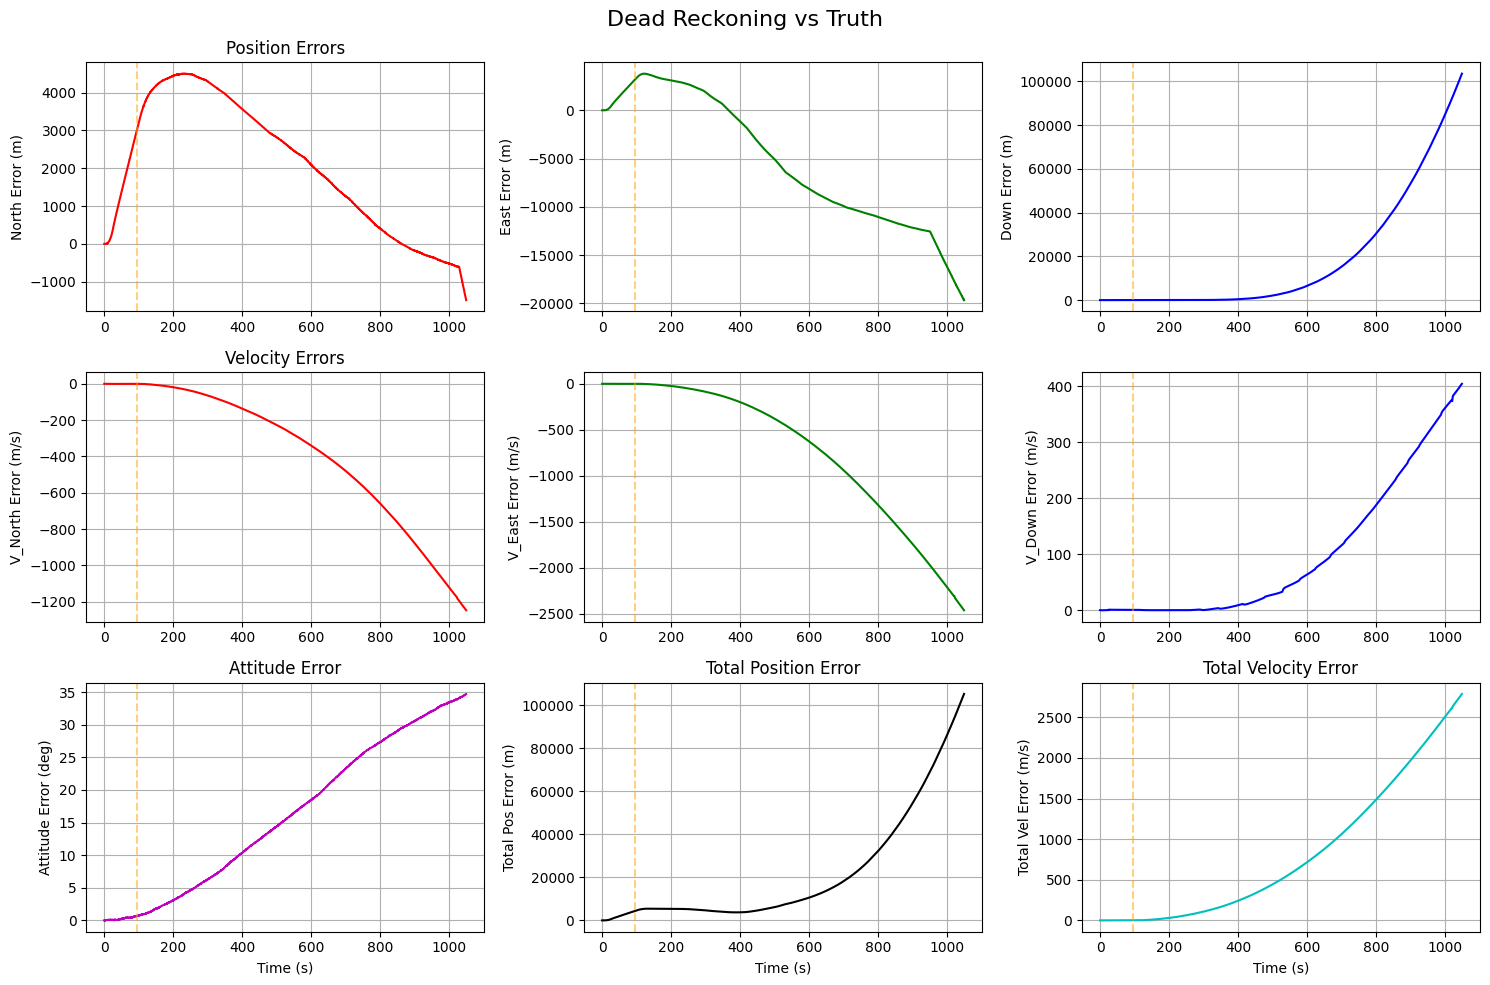


ERROR STATISTICS

Position error (m):
  Mean:  21676.60
  Std:   26469.37
  Max:   105360.96
  Final: 105360.96

Velocity error (m/s):
  Mean:    815.94
  Std:     836.98
  Max:    2788.34
  Final:  2788.34

Attitude error (deg):
  Mean:     16.01
  Std:      11.39
  Max:      34.70
  Final:    34.70

TESTING AROUND APOGEE

Running dead reckoning from t=89.5s to t=99.5s
  t=  89.5s: Pos_err=33773.44m, Vel_err= 71.73m/s, Att_err=22.71°
  t=  90.5s: Pos_err=33827.96m, Vel_err= 71.80m/s, Att_err=22.69°
  t=  91.5s: Pos_err=33882.39m, Vel_err= 71.87m/s, Att_err=22.70°
  t=  92.5s: Pos_err=33937.71m, Vel_err= 71.94m/s, Att_err=22.68°
  t=  93.5s: Pos_err=33992.80m, Vel_err= 72.01m/s, Att_err=22.68°
  t=  94.5s: Pos_err=34047.82m, Vel_err= 72.08m/s, Att_err=22.67°
  t=  95.5s: Pos_err=34103.23m, Vel_err= 72.16m/s, Att_err=22.65°
  t=  96.5s: Pos_err=34159.27m, Vel_err= 72.23m/s, Att_err=22.62°
  t=  97.5s: Pos_err=34214.88m, Vel_err= 72.37m/s, Att_err=22.59°
  t=  98.5s: Pos_err=34270.74m, 

In [22]:
"""
EKF Testing Framework - Updated for Your MATLAB Data Format
"""

import numpy as np
import cmsisdsp as dsp
from scipy.io import loadmat
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Import your EKF functions (from v1.1)
# from ekf_propagation import *

DTYPE = np.float32

class MATLABDataLoader:
    """
    Loads your specific MATLAB test data format
    """
    def __init__(self, mat_file_path):
        """Load the .mat file and extract data"""
        print(f"Loading MATLAB data from: {mat_file_path}")
        self.data = loadmat(mat_file_path)

        # The data is in a structured array under 'sim_data'
        sim_data = self.data['sim_data']

        # Extract fields from the structured array
        # Each field is accessed as sim_data[field_name][0,0]
        self.time = np.squeeze(sim_data['time'][0,0]).astype(DTYPE)
        self.acc = sim_data['acc'][0,0].astype(DTYPE)  # Accelerometer
        self.gyro = sim_data['gyro'][0,0].astype(DTYPE)  # Gyroscope

        # Biases and scale factors
        self.ba = sim_data['ba'][0,0].astype(DTYPE)  # Accel bias
        self.bg = sim_data['bg'][0,0].astype(DTYPE)  # Gyro bias
        self.Sa = sim_data['Sa'][0,0].astype(DTYPE)  # Accel scale factor
        self.Sg = sim_data['Sg'][0,0].astype(DTYPE)  # Gyro scale factor

        # Initial position
        self.LLA0 = np.squeeze(sim_data['LLA0'][0,0]).astype(DTYPE)

        # Truth data
        self.NED = sim_data['NED'][0,0].astype(DTYPE)  # NED position
        self.velI = sim_data['velI'][0,0].astype(DTYPE)  # Inertial velocity
        self.q = sim_data['q'][0,0].astype(DTYPE)  # True quaternions

        # Sensor measurements
        self.GPS = sim_data['GPS'][0,0].astype(DTYPE)  # GPS (has NaN when unavailable)
        self.magB = sim_data['magB'][0,0].astype(DTYPE)  # Magnetometer body
        self.magI = np.squeeze(sim_data['magI'][0,0]).astype(DTYPE)  # Mag inertial reference
        self.baro = np.squeeze(sim_data['baro'][0,0]).astype(DTYPE)  # Barometer
        self.press = np.squeeze(sim_data['press'][0,0]).astype(DTYPE)  # Pressure

        # Apogee index
        self.apogee_idx = int(sim_data['apogee_idx'][0,0][0,0])

        # Print data summary
        self.print_summary()

    def print_summary(self):
        """Print summary of loaded data"""
        print("\n" + "="*60)
        print("MATLAB DATA SUMMARY")
        print("="*60)
        print(f"Time span: {self.time[0]:.2f} to {self.time[-1]:.2f} seconds")
        print(f"Total samples: {len(self.time)}")
        print(f"Sample rate: {1.0/(self.time[1]-self.time[0]):.1f} Hz")
        print(f"Initial LLA: {self.LLA0}")
        print(f"Apogee at index: {self.apogee_idx} (t={self.time[self.apogee_idx]:.2f}s)")

        # Check GPS availability
        gps_valid = ~np.isnan(self.GPS[0, :])
        gps_rate = np.sum(gps_valid) / (self.time[-1] - self.time[0])
        print(f"GPS measurements: {np.sum(gps_valid)} samples (~{gps_rate:.1f} Hz)")

        # Check mag availability
        mag_valid = ~np.isnan(self.magB[0, :])
        mag_rate = np.sum(mag_valid) / (self.time[-1] - self.time[0])
        print(f"Mag measurements: {np.sum(mag_valid)} samples (~{mag_rate:.1f} Hz)")

        # Flight profile
        max_alt = np.max(-self.NED[2, :])  # NED down is negative altitude
        max_vel = np.max(np.linalg.norm(self.velI, axis=0))
        print(f"\nFlight profile:")
        print(f"  Max altitude: {max_alt:.1f} m")
        print(f"  Max velocity: {max_vel:.1f} m/s")
        print(f"  Apogee altitude: {-self.NED[2, self.apogee_idx]:.1f} m")


class EKFDeadReckoningTester:
    """
    Test dead reckoning performance against your MATLAB data
    """
    def __init__(self, matlab_data):
        self.data = matlab_data

        # EKF parameters matching MATLAB
        self.dt = DTYPE(0.01)  # 100 Hz
        self.we = DTYPE(0.0)  # Earth rotation (set to 0 in your MATLAB)
        self.a = DTYPE(6378137.0)
        self.b = DTYPE(6356752.31425)
        self.e2 = DTYPE(1.0 - (self.b/self.a)**2)

        # State storage
        self.state_history = []
        self.error_history = {
            'pos_north': [],
            'pos_east': [],
            'pos_down': [],
            'vel_north': [],
            'vel_east': [],
            'vel_down': [],
            'attitude': []
        }

    def initialize_state(self):
        """Initialize state from MATLAB initial conditions"""
        state = np.zeros(22, dtype=DTYPE)

        # Initial quaternion
        state[0:4] = self.data.q[:, 0]

        # Initial position (LLA0)
        state[4:7] = self.data.LLA0

        # Initial velocity (should be zero)
        state[7:10] = self.data.velI[:, 0]

        # Initial biases from data
        state[10:13] = self.data.bg[:, 0]  # Gyro bias
        state[13:16] = self.data.ba[:, 0]  # Accel bias
        state[16:19] = self.data.Sg[:, 0] - 1.0  # Gyro scale factor (stored as 1+sf)
        state[19:22] = self.data.Sa[:, 0] - 1.0  # Accel scale factor

        return state

    def run_test(self, start_idx=0, end_idx=None):
        """Run dead reckoning through the trajectory"""
        if end_idx is None:
            end_idx = len(self.data.time)

        print(f"\nRunning dead reckoning from t={self.data.time[start_idx]:.1f}s to t={self.data.time[end_idx-1]:.1f}s")

        # Initialize
        self.state = self.initialize_state()
        self.state_history = []

        # Clear error history
        for key in self.error_history:
            self.error_history[key] = []

        # Progress reporting
        n_samples = end_idx - start_idx
        report_interval = max(1, n_samples // 10)

        for i in range(start_idx, end_idx):
            # Create IMU data
            imu = IMUData(
                gyro=self.data.gyro[:, i],
                accel=self.data.acc[:, i]
            )

            # Propagate
            self.state = propagate_state(
                self.state, imu, self.we, self.dt, self.a, self.e2
            )

            # Store state
            self.state_history.append(self.state.copy())

            # Compute errors
            self.compute_errors(i)

            # Progress report
            if (i - start_idx) % report_interval == 0:
                t = self.data.time[i]
                pos_err = np.sqrt(
                    self.error_history['pos_north'][-1]**2 +
                    self.error_history['pos_east'][-1]**2 +
                    self.error_history['pos_down'][-1]**2
                )
                vel_err = np.sqrt(
                    self.error_history['vel_north'][-1]**2 +
                    self.error_history['vel_east'][-1]**2 +
                    self.error_history['vel_down'][-1]**2
                )
                att_err = self.error_history['attitude'][-1]

                print(f"  t={t:6.1f}s: Pos_err={pos_err:8.2f}m, "
                      f"Vel_err={vel_err:6.2f}m/s, Att_err={att_err:5.2f}°")

        self.state_history = np.array(self.state_history)
        print("\nDead reckoning complete!")
        
        # Print final state with quaternion, NED, and LLA
        print("\n" + "="*60)
        print("FINAL STATE")
        print("="*60)
        
        # Final quaternion
        q_final = self.state[0:4]
        print(f"Quaternion: [{q_final[0]:.6f}, {q_final[1]:.6f}, {q_final[2]:.6f}, {q_final[3]:.6f}]")
        
        # Final LLA position
        lla_final = self.state[4:7]
        print(f"LLA Position: Lat={lla_final[0]:.6f}°, Lon={lla_final[1]:.6f}°, Alt={lla_final[2]:.1f}m")
        
        # Convert LLA to NED for final position
        ned_final = self.lla2ned(lla_final, self.data.LLA0)
        print(f"NED Position: North={ned_final[0]:.1f}m, East={ned_final[1]:.1f}m, Down={ned_final[2]:.1f}m")
        
        # Final velocity (already in NED frame)
        vel_final = self.state[7:10]
        print(f"NED Velocity: North={vel_final[0]:.2f}m/s, East={vel_final[1]:.2f}m/s, Down={vel_final[2]:.2f}m/s")

    def compute_errors(self, idx):
        """Compute errors vs truth"""
        # Convert estimated LLA to NED
        lla_est = self.state[4:7]
        ned_est = self.lla2ned(lla_est, self.data.LLA0)

        # True NED
        ned_true = self.data.NED[:, idx]

        # Position errors
        self.error_history['pos_north'].append(ned_est[0] - ned_true[0])
        self.error_history['pos_east'].append(ned_est[1] - ned_true[1])
        self.error_history['pos_down'].append(ned_est[2] - ned_true[2])

        # Velocity errors
        vel_est = self.state[7:10]
        vel_true = self.data.velI[:, idx]
        self.error_history['vel_north'].append(vel_est[0] - vel_true[0])
        self.error_history['vel_east'].append(vel_est[1] - vel_true[1])
        self.error_history['vel_down'].append(vel_est[2] - vel_true[2])

        # Attitude error
        q_true = self.data.q[:, idx]
        q_est = self.state[0:4]

        # Error quaternion
        q_err = self.quat_mult(q_true, self.quat_conj(q_est))
        angle_error = 2 * np.arctan2(np.linalg.norm(q_err[1:4]), np.abs(q_err[0]))
        self.error_history['attitude'].append(np.degrees(angle_error))

    def lla2ecef(self, lla):
        """
        Convert LLA (Latitude, Longitude, Altitude) to ECEF (Earth-Centered Earth-Fixed)
        
        Args:
            lla: [latitude (deg), longitude (deg), altitude (m)]
        
        Returns:
            ecef: [x, y, z] in meters
        
        Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equations A.238-A.239
        Verified with Google Maps
        """
        lla = np.array(lla, dtype=DTYPE).flatten()
        
        # WGS84 parameters
        a = DTYPE(6378137.0)        # semi-major axis [m]
        b = DTYPE(6356752.3124)     # semi-minor axis [m]  
        e = DTYPE(0.08181919)       # eccentricity
        
        phi = lla[0]      # latitude in degrees
        lambda_ = lla[1]  # longitude in degrees
        h = lla[2]        # altitude in meters
        
        # Convert to radians for trig functions
        phi_rad = phi * np.pi / 180.0
        lambda_rad = lambda_ * np.pi / 180.0
        
        # Compute N (prime vertical radius of curvature) - equation A.238
        sin_phi = np.sin(phi_rad)
        N = a / np.sqrt(1.0 - (e * sin_phi)**2)
        
        # Compute ECEF coordinates - equation A.239
        cos_phi = np.cos(phi_rad)
        cos_lambda = np.cos(lambda_rad)
        sin_lambda = np.sin(lambda_rad)
        
        x = (N + h) * cos_phi * cos_lambda
        y = (N + h) * cos_phi * sin_lambda
        z = (N * (1.0 - e**2) + h) * sin_phi
        
        ecef = np.array([x, y, z], dtype=DTYPE)
        
        return ecef


    def ecef2ned(self, ecef, lla0):
        """
        Convert ECEF to NED (North-East-Down) frame relative to reference point
        
        Args:
            ecef: [x, y, z] in ECEF frame [m]
            lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
        
        Returns:
            ned: [north, east, down] in meters relative to lla0
        
        Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equation A.242
        """
        ecef = np.array(ecef, dtype=DTYPE).flatten()
        lla0 = np.array(lla0, dtype=DTYPE).flatten()
        
        # Get ECEF of NED origin
        ecef0 = lla2ecef(lla0)
        
        # Reference point angles
        phi = lla0[0]      # latitude in degrees
        lambda_ = lla0[1]  # longitude in degrees
        
        # Convert to radians
        phi_rad = phi * np.pi / 180.0
        lambda_rad = lambda_ * np.pi / 180.0
        
        # Precompute trig functions
        s1 = np.sin(phi_rad)
        c1 = np.cos(phi_rad)
        s2 = np.sin(lambda_rad)
        c2 = np.cos(lambda_rad)
        
        # Build ECEF to NED rotation matrix (DCM) - equation A.242
        # This transforms from ECEF frame to NED frame centered at lla0
        Ae2n = np.array([
            [-s1*c2, -s1*s2,  c1],
            [-s2,     c2,     0.0],
            [-c1*c2, -c1*s2, -s1]
        ], dtype=DTYPE)
        
        # Compute relative ECEF position using CMSIS-DSP
        delta_ecef = dsp.arm_sub_f32(ecef, ecef0)
        
        # Transform to NED using matrix-vector multiply
        # Using CMSIS-DSP dot products for each row
        ned = np.zeros(3, dtype=DTYPE)
        for i in range(3):
            ned[i] = dsp.arm_dot_prod_f32(Ae2n[i, :], delta_ecef)
        
        return ned


    def lla2ned(self, lla, lla0):
        """
        Convert LLA to NED frame relative to reference point
        
        Args:
            lla: [latitude (deg), longitude (deg), altitude (m)]
            lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
        
        Returns:
            ned: [north, east, down] in meters relative to lla0
        
        This is the main function used in the EKF for position conversions.
        Combines lla2ecef and ecef2ned transformations.
        """
        # Convert LLA to ECEF
        ecef = lla2ecef(lla)
        
        # Convert ECEF to NED relative to reference
        ned = ecef2ned(ecef, lla0)
        
        return ned


    def quat_mult(self, q1, q2):
        """Quaternion multiplication"""
        return dsp.arm_quaternion_product_single_f32(q1,q2)

    def quat_conj(self, q):
        """Quaternion conjugate"""
        return dsp.arm_quaternion_conjugate_f32(q)

    def plot_results(self):
        """Generate comparison plots"""
        time = self.data.time[:len(self.state_history)]

        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
        fig.suptitle('Dead Reckoning vs Truth', fontsize=16)

        # Position errors
        axes[0,0].plot(time, self.error_history['pos_north'], 'r-')
        axes[0,0].set_ylabel('North Error (m)')
        axes[0,0].grid(True)
        axes[0,0].set_title('Position Errors')

        axes[0,1].plot(time, self.error_history['pos_east'], 'g-')
        axes[0,1].set_ylabel('East Error (m)')
        axes[0,1].grid(True)

        axes[0,2].plot(time, self.error_history['pos_down'], 'b-')
        axes[0,2].set_ylabel('Down Error (m)')
        axes[0,2].grid(True)

        # Velocity errors
        axes[1,0].plot(time, self.error_history['vel_north'], 'r-')
        axes[1,0].set_ylabel('V_North Error (m/s)')
        axes[1,0].grid(True)
        axes[1,0].set_title('Velocity Errors')

        axes[1,1].plot(time, self.error_history['vel_east'], 'g-')
        axes[1,1].set_ylabel('V_East Error (m/s)')
        axes[1,1].grid(True)

        axes[1,2].plot(time, self.error_history['vel_down'], 'b-')
        axes[1,2].set_ylabel('V_Down Error (m/s)')
        axes[1,2].grid(True)

        # Attitude and total errors
        axes[2,0].plot(time, self.error_history['attitude'], 'm-')
        axes[2,0].set_ylabel('Attitude Error (deg)')
        axes[2,0].set_xlabel('Time (s)')
        axes[2,0].grid(True)
        axes[2,0].set_title('Attitude Error')

        # Total position error
        pos_err_total = np.sqrt(
            np.array(self.error_history['pos_north'])**2 +
            np.array(self.error_history['pos_east'])**2 +
            np.array(self.error_history['pos_down'])**2
        )
        axes[2,1].plot(time, pos_err_total, 'k-')
        axes[2,1].set_ylabel('Total Pos Error (m)')
        axes[2,1].set_xlabel('Time (s)')
        axes[2,1].grid(True)
        axes[2,1].set_title('Total Position Error')

        # Total velocity error
        vel_err_total = np.sqrt(
            np.array(self.error_history['vel_north'])**2 +
            np.array(self.error_history['vel_east'])**2 +
            np.array(self.error_history['vel_down'])**2
        )
        axes[2,2].plot(time, vel_err_total, 'c-')
        axes[2,2].set_ylabel('Total Vel Error (m/s)')
        axes[2,2].set_xlabel('Time (s)')
        axes[2,2].grid(True)
        axes[2,2].set_title('Total Velocity Error')

        # Mark apogee
        apogee_time = self.data.time[self.data.apogee_idx]
        for ax in axes.flat:
            ax.axvline(apogee_time, color='orange', linestyle='--', alpha=0.5, label='Apogee')

        plt.tight_layout()
        plt.show()

        # Print statistics
        self.print_statistics()

    def print_statistics(self):
        """Print error statistics"""
        print("\n" + "="*60)
        print("ERROR STATISTICS")
        print("="*60)

        # Compute total errors
        pos_err_total = np.sqrt(
            np.array(self.error_history['pos_north'])**2 +
            np.array(self.error_history['pos_east'])**2 +
            np.array(self.error_history['pos_down'])**2
        )

        vel_err_total = np.sqrt(
            np.array(self.error_history['vel_north'])**2 +
            np.array(self.error_history['vel_east'])**2 +
            np.array(self.error_history['vel_down'])**2
        )

        att_err = np.array(self.error_history['attitude'])

        print(f"\nPosition error (m):")
        print(f"  Mean:  {np.mean(pos_err_total):8.2f}")
        print(f"  Std:   {np.std(pos_err_total):8.2f}")
        print(f"  Max:   {np.max(pos_err_total):8.2f}")
        print(f"  Final: {pos_err_total[-1]:8.2f}")

        print(f"\nVelocity error (m/s):")
        print(f"  Mean:  {np.mean(vel_err_total):8.2f}")
        print(f"  Std:   {np.std(vel_err_total):8.2f}")
        print(f"  Max:   {np.max(vel_err_total):8.2f}")
        print(f"  Final: {vel_err_total[-1]:8.2f}")

        print(f"\nAttitude error (deg):")
        print(f"  Mean:  {np.mean(att_err):8.2f}")
        print(f"  Std:   {np.std(att_err):8.2f}")
        print(f"  Max:   {np.max(att_err):8.2f}")
        print(f"  Final: {att_err[-1]:8.2f}")


# Test execution
def test_dead_reckoning(mat_file_path):
    """Main test function"""
    print("="*60)
    print("DEAD RECKONING VALIDATION")
    print("Python CMSIS-DSP vs MATLAB Truth")
    print("="*60)

    # Load data
    matlab_data = MATLABDataLoader(mat_file_path)

    # Create tester
    tester = EKFDeadReckoningTester(matlab_data)

    # Test full trajectory
    tester.run_test()

    # Generate plots
    tester.plot_results()

    # Test around apogee specifically
    print("\n" + "="*60)
    print("TESTING AROUND APOGEE")
    print("="*60)

    apogee_idx = matlab_data.apogee_idx
    start = max(0, apogee_idx - 500)  # 5 seconds before
    end = min(len(matlab_data.time), apogee_idx + 500)  # 5 seconds after

    tester_apogee = EKFDeadReckoningTester(matlab_data)
    tester_apogee.run_test(start, end)

    return tester, matlab_data


if __name__ == "__main__":
    # Run the test
    tester, data = test_dead_reckoning(TEST_DATA_FILE_PATH)